In [110]:
from google.colab import drive

In [111]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
!pip install contractions

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
from bs4 import BeautifulSoup  ## to remove HTML tags
import nltk
from nltk.tokenize import word_tokenize  ## tokenize
import re ##regular expression
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import contractions                                     # Import contractions library.
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [114]:
nltk.download(['averaged_perceptron_tagger', 'punkt', 'wordnet'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
df = pd.read_csv("/content/drive/My Drive/AIML/Tweets.csv")
df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [116]:
df.shape

(14640, 15)

In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [118]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


As we see from above data, there are 0's on 
1. retweet_count: It is not necessary that all the tweets needs to be retweeted. So, we can ignore it
2. negativereason_confidence: For non negative reason, the reason for negativity is not required. So, it may be 0 for those cases/

In [119]:
for col in ('airline_sentiment','negativereason','airline','airline_sentiment_gold'):
    if(df[col].dtype == object):
        ##print("Column:",col)
        print("Grouping",df[col].value_counts())
        #print()
        print("No.of null values",df[col].isnull().sum())
        print()

Grouping negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
No.of null values 0

Grouping Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64
No.of null values 5462

Grouping United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64
No.of null values 0

Grouping negative    32
positive     5
neutral      3
Name: airline_sentiment_gold, dtype: int64
No.of null values 14600



Quetion 2: Understand of data-columns: (5 Marks)
1. Drop all other columns except “text” and “airline_sentiment”.
2. Check the shape of data.
3. Print first 5 rows of data.

In [120]:
## Dropping all the columns except "text" and "airline_sentiment"
df_data = df[['text','airline_sentiment']]

In [121]:
df_data['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [122]:
#shape of data
df_data.shape

(14640, 2)

In [123]:
#first 5 rows of data
df_data.head(5)

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


Question 3: Text pre-processing: Data preparation. (20 Marks)
1. Html tag removal.
2. Tokenization.
3. Remove the numbers.
4. Removal of Special Characters and Punctuations.
5. Conversion to lowercase.
6. Lemmatize or stemming.
7. Join the words in the list to convert back to text string in the dataframe. (So that each row contains the data in text format.)
8. Print first 5 rows of data after pre-processing.

In [124]:
#1. removing HTML tabs
def html_remove(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

df_data['cleaned_text'] = df_data['text'].apply(lambda x: html_remove(x))
#df_data.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
def replace_contractions(text):
    return contractions.fix(text)

df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: replace_contractions(x))
#df_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [126]:
def rem_tweet_words(text):
  text = re.sub(u'http\S+|@\S+|#', ' ', text)
  return text

df_data['cleaned_text'] = df_data['cleaned_text'].apply(lambda x: rem_tweet_words(x))
#df_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [127]:
#2. Tokenization
df_data['cleaned_text'] = df_data.apply(lambda tk: nltk.word_tokenize(tk['cleaned_text']), axis=1)
#df_data.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [128]:
def rem_num(text):
  new_text = []
  for text in text:
    text = re.sub(r'\d+', '', str(text))
    if text!='':
      new_text.append(text)
  return new_text

#df_data['text'] = df_data['text'].apply(lambda x: rem_num(x))
#df_data.text.tail(15)

In [129]:
## Removal of Special Characters and Punctuations.
#def rem_spe_chs(text):
#    text = re.sub("[^a-zA-Z]","",text)
#    return text

#data['text'] = data['text'].apply(lambda x: rem_spe_chs(x))
#data.head(5)

def rem_spe_chs(text):
    new_text = []
    for text in text:
        text = re.sub("[^a-zA-Z]","",str(text))
        if text != '':
            new_text.append(text)
    return new_text

In [130]:
## lower case conversion
def to_lower_case(text):
    new_text = []
    for text in text:
        text = text.lower()
        new_text.append(text)
    return new_text

In [131]:
data = df_data.copy()
data.head(5)

,text,airline_sentiment,cleaned_text
0,@VirginAmerica What @dhepburn said.,neutral,"[What, said, .]"
1,@VirginAmerica plus you've added commercials t...,positive,"[plus, you, have, added, commercials, to, the,..."
2,@VirginAmerica I didn't today... Must mean I n...,neutral,"[I, did, not, today, ..., Must, mean, I, need,..."
3,@VirginAmerica it's really aggressive to blast...,negative,"[it, is, really, aggressive, to, blast, obnoxi..."
4,@VirginAmerica and it's a really big bad thing...,negative,"[and, it, is, a, really, big, bad, thing, abou..."


In [132]:
def normalize(text):
    text = rem_num(text)
    text = rem_spe_chs(text)
    text = to_lower_case(text)
    return ' '.join(text)

In [133]:
data['cleaned_text'] = data.apply(lambda row: normalize(row['cleaned_text']), axis=1)
data.head()

,text,airline_sentiment,cleaned_text
0,@VirginAmerica What @dhepburn said.,neutral,what said
1,@VirginAmerica plus you've added commercials t...,positive,plus you have added commercials to the experie...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,i did not today must mean i need to take anoth...
3,@VirginAmerica it's really aggressive to blast...,negative,it is really aggressive to blast obnoxious ent...
4,@VirginAmerica and it's a really big bad thing...,negative,and it is a really big bad thing about it


In [134]:
## Lemmatize.
lemmatizer = WordNetLemmatizer()

In [135]:
def lemmatize_list(text):
  new_text = []
  sentence_words = nltk.word_tokenize(text)
  for text in sentence_words:
    new_text.append(lemmatizer.lemmatize(text, pos='v'))
  return ' '.join(new_text)

In [136]:
data['lem'] = data.apply(lambda row: lemmatize_list(row['cleaned_text']), axis=1)
data.head()

,text,airline_sentiment,cleaned_text,lem
0,@VirginAmerica What @dhepburn said.,neutral,what said,what say
1,@VirginAmerica plus you've added commercials t...,positive,plus you have added commercials to the experie...,plus you have add commercials to the experienc...
2,@VirginAmerica I didn't today... Must mean I n...,neutral,i did not today must mean i need to take anoth...,i do not today must mean i need to take anothe...
3,@VirginAmerica it's really aggressive to blast...,negative,it is really aggressive to blast obnoxious ent...,it be really aggressive to blast obnoxious ent...
4,@VirginAmerica and it's a really big bad thing...,negative,and it is a really big bad thing about it,and it be a really big bad thing about it


4.Vectorization:(10Marks)
1. Use CountVectorizer.
2. Use TfidfVectorizer.

1 . CountVectorizer.

In [137]:
## CountVectorizer (convert text data to number)
vectorizer = CountVectorizer()                # Keep only 1000 features as number of features will increase the processing time.
data_features_cv = vectorizer.fit_transform(data['lem'])
data_features_cv = data_features_cv.toarray()                        # Convert the data features to array.

In [138]:
data_features_cv.shape

(14640, 10169)

In [139]:
data['airline_sentiment'].replace({'negative': 0,'neutral': 1,'positive': 2},inplace=True)
labels = data['airline_sentiment']
#labels = labels.astype('int')

5.Fit and evaluate model using countvectorization.

In [140]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(data_features_cv, labels, test_size=0.3, random_state=10)

In [141]:
forest = RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs = 10)
forest = forest.fit(X_train, y_train)
print(np.mean(cross_val_score(forest, data_features_cv, labels, cv=10)))

0.7628415300546447


In [142]:
result_cv = forest.predict(X_test)

[[2573  119   39]
 [ 490  424   44]
 [ 262   67  374]]


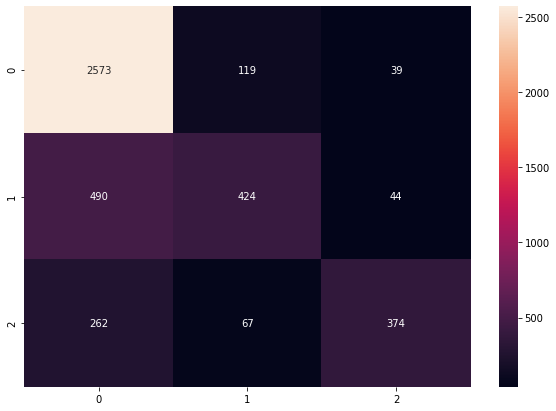

In [143]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result_cv)

print(conf_mat)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"], columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

2. TfidfVectorizer

In [144]:
# Using TfidfVectorizer to convert text data to numbers.
vectorizer = TfidfVectorizer()
data_features_tv = vectorizer.fit_transform(data['lem'])
data_features_tv = data_features_tv.toarray()
data_features_tv.shape

(14640, 10169)

In [145]:
# Split data into training and testing set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features_tv, labels, test_size=0.3, random_state=10)

In [146]:
forest1 = RandomForestClassifier(n_estimators=100,class_weight='balanced',n_jobs = 10)
forest1 = forest1.fit(X_train, y_train)
print(np.mean(cross_val_score(forest1, data_features_tv, labels, cv=10)))

0.7565573770491802


In [147]:
result_tv = forest1.predict(X_test)

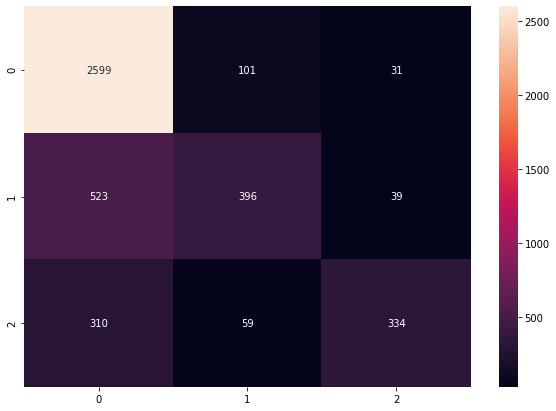

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result_tv)

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

6.Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your modelon this dataset. (8 Marks)

1. This problem statement contains the sentiment analysis of various users about US Airline
2. Sentiment analysis are captured from the users tweets.
3. Dataset contains consumers tweet and there sentiment captured as "Postive", "Negative" and "Neutral"
4. The main objective is to build a model for text-classification.
5. As part of Data Preparation, Text Pre-Processing was carried out, which contains,
  1. Removal of HTML tags
  2. Removal of tweeted to or tweeted about(ex: @VirginAmerica)
  3. Replacing Contractions.
  4. Tokenization
  5. Removal of Numbers
  6. Removal of special characters
  7. Lower case convertion
  8. Lemmatize
6. Vectorisation is taken care(both CountVectorizer and TfidfVectorizer), to convert the pre-processed text into numbers.
7. Once the model is build, the test values are predicted and compared with actual values.
8. From above result, we can see that our model perform good and predict 75% of data correctly.
9. We can still increase the accuracy by tuning the hyper parameters. As time is the biggest concern, we couldnt make more changes in the model.
10. Accuracy can be increased by including few more pre-processing techniques.